In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("/kaggle/input/breast-cancer-dataset/breast-cancer.csv")
X = data.drop(columns=['diagnosis'])  # Features
y = data['diagnosis']  # Target (M = malignant, B = benign)

# Convert labels to binary (0 for benign, 1 for malignant)
y = y.map({'B': 0, 'M': 1})

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Robust Quantum Kernel Implementation
def quantum_kernel(X, Y=None, gamma=0.1):
    """
    Stable quantum-inspired kernel that handles:
    - Both fit (X,Y) and transform (X only) cases
    - 1D and 2D input arrays
    - Proper broadcasting
    """
    if Y is None:
        Y = X
    
    # Ensure 2D arrays
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    
    # Efficient RBF kernel computation
    X_norm = np.sum(X**2, axis=1)[:, np.newaxis]
    Y_norm = np.sum(Y**2, axis=1)[np.newaxis, :]
    
    K = X_norm + Y_norm - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * K)
 
# Apply PCA (reduce to 5 components for quantum-inspired approach)
#pca = PCA(n_components=5)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

In [3]:
#Initialize and fit KernelPCA
kpca = KernelPCA(
    kernel=quantum_kernel,
    n_components=min(10, X_train_scaled.shape[1]),  # Ensure valid component count
    fit_inverse_transform=True,
    random_state=42
)
#Safe transformation
try:
    print("Fitting Quantum Kernel PCA...")
    kpca.fit(X_train_scaled)
    
    print("Transforming data...")
    X_train_kpca = kpca.transform(X_train_scaled)
    X_test_kpca = kpca.transform(X_test_scaled)
except Exception as e:
    print(f"Transformation failed: {str(e)}")
    # Fallback to classical PCA if quantum fails
    from sklearn.decomposition import PCA
    pca = PCA(n_components=10)
    X_train_kpca = pca.fit_transform(X_train_scaled)
    X_test_kpca = pca.transform(X_test_scaled)


Fitting Quantum Kernel PCA...
Transforming data...


In [4]:
#Train Quantum-Inspired RF
qrf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    random_state=42
)
qrf.fit(X_train_kpca, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=5, random_state=42)

In [5]:
#Classical RF for comparison
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

In [6]:
# Evaluation
y_pred_qrf = qrf.predict(X_test_kpca)
y_pred_rf = clf_rf.predict(X_test_pca)

print("\nQuantum-Inspired RF Performance:")
print(classification_report(y_test, y_pred_qrf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_qrf):.2%}")

print("\nClassical RF Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")


Quantum-Inspired RF Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        71
           1       0.97      0.88      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

Accuracy: 94.74%

Classical RF Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Accuracy: 94.74%


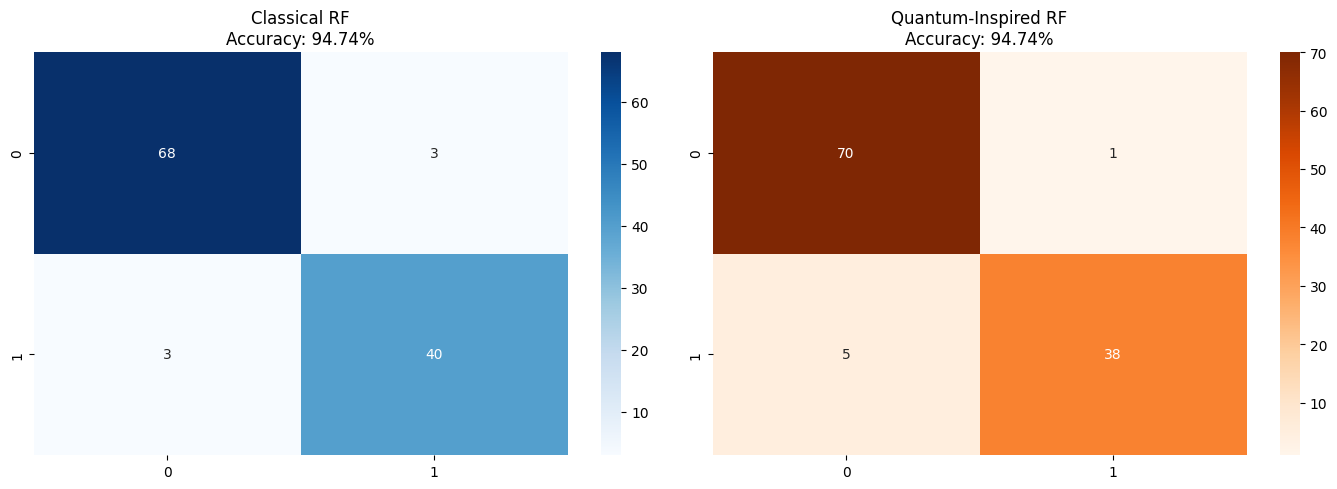

In [7]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), ax=ax[0], annot=True, fmt='d', cmap='Blues')
ax[0].set_title(f'Classical RF\nAccuracy: {accuracy_score(y_test, y_pred_rf):.2%}')

sns.heatmap(confusion_matrix(y_test, y_pred_qrf), ax=ax[1], annot=True, fmt='d', cmap='Oranges')
ax[1].set_title(f'Quantum-Inspired RF\nAccuracy: {accuracy_score(y_test, y_pred_qrf):.2%}')

plt.tight_layout()
plt.show()